In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from classy import Class
from matplotlib.lines import Line2D
from smt.sampling_methods import LHS
from matplotlib.pyplot import cm
from uqpylab import sessions
from scipy.interpolate import interp1d
from scipy.spatial.distance import pdist
import statistics as st
import os, sys, warnings
from configparser import ConfigParser
from itertools import chain
import math

In [2]:
import os

# Where to save the figures

IMAGES_PATH = './'
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    plt.savefig(path, format=fig_extension, dpi=resolution,bbox_inches='tight')

$$
p(k) = 2\pi^2 \frac{A_s}{k^3} \left(\frac{k}{k_*}\right)^{n_s-1}|\delta_m|^2 \Longrightarrow  \delta_m = \left(\frac{p(k)}{2\pi^2 \frac{A_s}{k^3} \left(\frac{k}{k_*}\right)^{n_s-1}}\right)^{1/2}
$$

In [3]:
z_list = [0, 0.5]

num_out = 12

kk_arr = np.logspace(np.log10(1.6e-02), np.log10(9.4), 1000)

mu_lin_hi = [[] for _ in range(num_out)]
mu_nl_hi = [[] for _ in range(num_out)]

mu_lin_class = [[] for _ in range(num_out)]
mu_nl_class = [[] for _ in range(num_out)]




for i in range(num_out):

    for root, subdirs, files in os.walk('./'):

        for direcname in subdirs:

            if direcname.endswith('_' + str(i)):

                direc_path = os.path.join(root, direcname)
                os.chdir(direc_path)

                # changing the directory

                Pk_m_lin_lists = []
                Pk_m_nl_lists = []
                transfer_lists = []

                for root, subdirs, files in os.walk('./'):

                    # Reading A_s and n_s from the ini file

                    parser = ConfigParser()
                    with open("file_classparameters.ini") as lines:
                        lines = chain(("[top]",), lines) # This line produce a fake section header called top
                        parser.read_file(lines)
                        
                    k_pivot = float(parser.get("top", "k_pivot"))
                    A_s = float(parser.get("top", "A_s"))
                    n_s = float(parser.get("top", "n_s"))
                    Omega_b = float(parser.get("top", "Omega_b"))
                    Omega_cdm = float(parser.get("top", "Omega_cdm"))
                    Omega_ur = float(parser.get("top", "Omega_ur"))
                    Omega_g = float(parser.get("top", "Omega_g"))
                    
                    h = float(parser.get("top", "h"))
                    # Extracting the second value of w0
                    w0_values = parser.get("top", "expansion_smg").split(",")
                    w0 = float(w0_values[1])
#                     print(w0)
                    parameters_smg_values = parser.get("top", "parameters_smg").split(",")
                    parameters_smg = float(parameters_smg_values[0])
                    cs2 = 3*(1+w0)/parameters_smg
#                     print(cs2)




                    # Reading background files
                    hi_back = np.loadtxt('file_classbackground.dat').T

                    # recovering redshifts at which background quantities are calculated
                    f_H = interp1d(hi_back[0], hi_back[3], kind="cubic")
                    f_rho_smg = interp1d(hi_back[0], hi_back[19], kind="cubic")
                    f_rho_b = interp1d(hi_back[0], hi_back[10], kind="cubic")
                    f_rho_cdm = interp1d(hi_back[0], hi_back[11], kind="cubic")


                    for filename in files:
                        if filename.endswith('tk.dat'):
                            file_path = os.path.join(root, filename)
                            transfer_lists.append(file_path)
                            transfer_lists.sort()

                    for filename in files:
                        if filename.endswith('pk.dat'):
                            file_path = os.path.join(root, filename)
                            Pk_m_lin_lists.append(file_path)
                            Pk_m_lin_lists.sort()


                    for filename in files:
                        if filename.endswith('pk_nl.dat'):
                            file_path = os.path.join(root, filename)
                            Pk_m_nl_lists.append(file_path)
                            Pk_m_nl_lists.sort()



                    for zind, z_val in enumerate(z_list): 

                        rho_m_hi = f_rho_b(z_val)+f_rho_cdm(z_val)
                        rho_fld_hi = f_rho_smg(z_val)

                        kk, P_lin = np.loadtxt(Pk_m_lin_lists[zind], usecols=[0,1], unpack = True)
                        f_pk_lin = interp1d(kk, P_lin, kind='cubic')

                        kk , P_nl = np.loadtxt(Pk_m_nl_lists[zind], usecols=[0,1], unpack = True)
                        f_pk_nl = interp1d(kk, P_nl, kind='cubic')
                        
                        

                        hi_tran = np.loadtxt(transfer_lists[zind]).T
                        
                        f_pi = interp1d(hi_tran[0], hi_tran[5], kind="cubic")
                        f_pi_prime = interp1d(hi_tran[0], hi_tran[6], kind="cubic")
                        f_delta_b = interp1d(hi_tran[0], hi_tran[2], kind="cubic")
                        f_delta_cdm = interp1d(hi_tran[0], hi_tran[3], kind="cubic")
                        
#                         d_fld_hi = ((1+w0)/cs2)*(-((3*cs2)-1)*(f_H(z_val)*(-f_pi(kk_arr))) - f_pi_prime(kk_arr))
                        
#                         delta_m_lin_hi =((P_lin/(2*np.pi**2))/(A_s*(kk**(-3))*(kk*h/k_pivot)**(n_s-1)))**(1/2)
#                         delta_m_nl_hi =((P_nl/(2*np.pi**2))/(A_s*(kk**(-3))*(kk*h/k_pivot)**(n_s-1)))**(1/2)
                        
#                         mu_lin_hi[i].append(1 - (rho_fld_hi*d_fld_hi)/(rho_m_hi*delta_m_lin_hi))
#                         mu_nl_hi[i].append(1 - (rho_fld_hi*d_fld_hi)/(rho_m_hi*delta_m_nl_hi))


                        #Interpolating delta_DE with wavenumbers
                        #f_delta_fld = interp1d(k_trans, Transfers[4], kind='cubic')

                        

                        d_fld_hi = ((1+w0)/cs2)*(-((3*cs2)-1)*(f_H(z_val)*(-f_pi(kk_arr))) - f_pi_prime(kk_arr))

                        delta_m_lin_hi =((f_pk_lin(kk_arr)/(2*np.pi**2))/(A_s*(kk_arr**(-3))*(kk_arr*h/k_pivot)**(n_s-1)))**(1/2)
                        delta_m_nl_hi =((f_pk_lin(kk_arr)/(2*np.pi**2))/(A_s*(kk_arr**(-3))*(kk_arr*h/k_pivot)**(n_s-1)))**(1/2)

                        mu_lin_hi[i].append(1 - (rho_fld_hi*d_fld_hi)/(rho_m_hi*delta_m_lin_hi))
                        mu_nl_hi[i].append(1 - (rho_fld_hi*d_fld_hi)/(rho_m_hi*delta_m_nl_hi))


                   
    M_lin = Class()
    M_nl = Class()


    linear =     {
            "Omega_scf": 0,
            "Omega_Lambda": 0,
            "Omega_b":Omega_b,
            "Omega_cdm":Omega_cdm,
            "Omega_g": Omega_g,
            "Omega_ur": Omega_ur,
            "n_s": n_s,
            "h": h,
            "w0_fld": w0,
            "cs2_fld": cs2,
            "A_s": A_s,
            "z_max_pk": 3,
            "output": "mTk,mPk",
            "use_ppf":"no",
            "P_k_max_h/Mpc": 130,
        }


    nonlinear = linear.copy()
    nonlinear["non linear"] = "Halofit"


    M_lin.set(linear)
    M_nl.set(nonlinear)

    # run class
    M_lin.compute()
    M_nl.compute()



    backgrounds = M_lin.get_background()

    f_rho_b = interp1d(backgrounds['z'], backgrounds['(.)rho_b'], kind='cubic')
    f_rho_cdm = interp1d(backgrounds['z'], backgrounds['(.)rho_cdm'], kind='cubic')
    f_rho_fld = interp1d(backgrounds['z'], backgrounds['(.)rho_fld'], kind='cubic')


    for zind, zi in enumerate(z_list):

        rho_b = f_rho_b(zi)
        rho_cdm = f_rho_cdm(zi)
        rho_fld = f_rho_fld(zi)

        rho_m = rho_b + rho_cdm 

        Transfers = M_lin.get_transfer(zi)


        f_delta_fld = interp1d(Transfers['k (h/Mpc)'], Transfers['d_fld'], kind='cubic')

        for k in kk_arr:
            delta_fld = (f_delta_fld(k)) 

            Pk_lin = (M_lin.pk(k*h,zi)*h**3)
            Pk_nl = (M_nl.pk(k*h,zi)*h**3)

            delta_m_lin =((Pk_lin/(2*np.pi**2))/(A_s*(k**(-3))*(k*h/k_pivot)**(n_s-1)))**(1/2)
            delta_m_nl = ((Pk_nl/(2*np.pi**2))/(A_s*(k**(-3))*(k*h/k_pivot)**(n_s-1)))**(1/2)

            mu_lin_class[i].append((1 - (delta_fld* rho_fld )/(rho_m*delta_m_lin)))
            mu_nl_class[i].append((1 - (delta_fld* rho_fld )/(rho_m*delta_m_nl)))

    os.chdir('../')

In [5]:
w0_list = np.loadtxt('../w0.txt')
w0_list 

array([-0.7  , -0.75 , -0.8  , -0.85 , -0.9  , -0.95 , -1.005, -1.05 ,
       -1.1  , -1.15 , -1.2  , -1.25 ])

Saving figure hiclass_tests


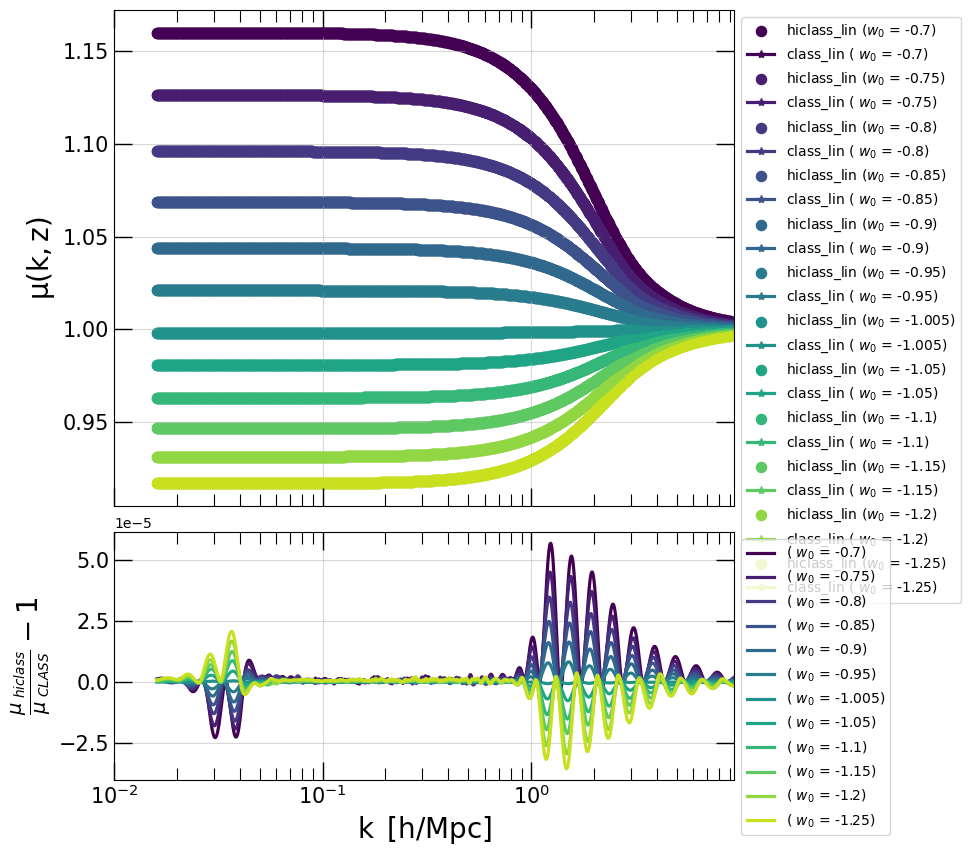

In [6]:
import warnings

warnings.filterwarnings("ignore")

fig, axs = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [2, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.07, wspace=0.23)

from matplotlib.cm import viridis
from matplotlib.cm import bwr

# Create a list of 10 evenly spaced values between 0 and 1
values = [i / num_out for i in range(num_out)]

# Get the viridis color map
cmap1 = viridis
cmap2 = bwr
# Get the colors from the viridis color map for the specified values
colors1 = [cmap1(v) for v in values]
colors2 = [cmap2(v) for v in values]

for ind, val in enumerate(zip(w0_list)):
    
    axs[0].scatter(
        kk_arr,
        mu_lin_hi[ind][0],
        linewidth=2.3,
        marker="o",
        label=f"hiclass_lin ($w_0$ = {w0_list[ind]})",
        color=colors1[ind],
    )
#     axs[0].scatter(
#         kk,
#         mu_nl_hi[ind][0],
#         linewidth=0.1,
#         marker="o",
#         label=f"hiclass_nl  ($w_0$ = {w0_list[ind]})",
#         color=colors1[ind],
#     )

    axs[0].plot(
        kk_arr,
        mu_lin_class[ind][0:1000],
        linewidth=2.3,
        marker="*",
        label=f"class_lin ( $w_0$ = {w0_list[ind]})",
        color=colors1[ind],
    )

#     axs[0].scatter(
#         kk,
#         mu_nl_class[ind],
#         linewidth=2,
#         marker="*",
#         label=f"class_nl ( $w_0$ = {w0_list[ind]})",
#         color=colors2[ind],
#     )

    # the ratio

    axs[1].plot(
        kk_arr,
        np.array(mu_lin_hi[ind][0]) / mu_lin_class[ind][0:1000] - 1,
        linewidth=2.3,
        label=f"( $w_0$ = {w0_list[ind]})",
        color=colors1[ind],
    )
#     axs[1].scatter(
#         kk,
#         np.array(mu_nl_hi[ind][0]) / mu_nl_class[ind] - 1,
#         label=f"class_nl ( $w_0$ = {w0_list[ind]})",
#         linewidth=1,
#         color=colors1[ind],
#     )

for i in range(2):
    axs[i].tick_params("both", length=13, width=1, which="major")
    axs[i].tick_params("both", length=8.5, width=0.8, which="minor")
    axs[i].tick_params(direction="in", which="major", labelsize=15)
    axs[i].tick_params(direction="in", which="minor")
    axs[i].yaxis.set_ticks_position("both")
    axs[i].xaxis.set_ticks_position("both")
    axs[i].set_xscale("log")
    # axs.set_yscale("log")
    #axs[i].set_ylim([0.94,1.05])
    axs[i].set_xlim([1.0e-2, 9.42])
    axs[i].grid(alpha=0.5)
    axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axs[0].set_ylabel(r"$\mathrm{\mu(k,z)}$", fontsize=20)    
    
axs[1].set_ylabel(r"$\frac{\mu_{~ hiclass}}{\mu_{~ CLASS}}-1$", fontsize=20)
axs[1].set_xlabel(r"$\mathrm{k} \,\,\,  \mathrm{[h/Mpc]}$", fontsize=20) 

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

save_fig('hiclass_tests')

In [237]:
path_back= "../../Desktop/cluster/Farbods_simulations/mu_paper/"


backgrounds =  np.loadtxt(path_back+'file_background.dat').T
#rho_m_kev = backgrounds[10][-1] + backgrounds[11][-1]
#rho_DE_kev = backgrounds[9][-1] 

f_rho_fld = interp1d(backgrounds[2], backgrounds[9], kind='cubic')
f_rho_cdm = interp1d(backgrounds[2], backgrounds[10], kind='cubic')
f_rho_b = interp1d(backgrounds[2], backgrounds[11], kind='cubic')

def rho_m_kev(val):
    return f_rho_cdm(1/(1+val))+f_rho_b(1/(1+val))

def rho_DE_kev(val):
    return f_rho_fld(1/(1+val))


In [238]:
path = "../../Desktop/cluster/Farbods_simulations/mu_paper/Full_simulations_20March2019-1280Mpc"

path_1280 = path + "/1280-cs_e7-w09-Kevolution/output/"

Pk_delta = []
Pk_delta_kess = []
mu_1280 = []
z_list_1280 = []

for root, subdirs, files in os.walk(path_1280):
    for filename in files:
        if filename.endswith('delta.dat'):
            file_path = os.path.join(root, filename)
            Pk_delta.append(file_path)
            Pk_delta.sort(reverse=True)
    for filename in files:
        if filename.endswith('delta_kess.dat'):
            file_path = os.path.join(root, filename)
            Pk_delta_kess.append(file_path)
            Pk_delta_kess.sort(reverse=True)

for i in range (len(Pk_delta)):
    
    k_1, PP_m = np.loadtxt(Pk_delta[i], usecols=[0,1], unpack = True)
    k_1, PP_DE = np.loadtxt(Pk_delta_kess[i], usecols=[0,1], unpack = True)
    
    with open(Pk_delta[i], 'r') as file:
    # Loop through each line in the file
        for line in file:
            # Check if the line starts with "# z ="
            if line.startswith("# redshift z="):
                # Extract the value of z from the line
                z_value = float(line.split('=')[1].strip())
                z_list_1280.append(z_value)
    
    mu_1280.append(1 + (rho_DE_kev(z_value)*np.sqrt(PP_DE))/(rho_m_kev(z_value)*np.sqrt(PP_m)))           


In [239]:
path_600 = "../../Desktop/cluster/Baobab/1800-600Mpc/"

Pk_delta = []
Pk_delta_kess = []
mu_600 = []
z_list_600 = []

for root, subdirs, files in os.walk(path_600):
    for filename in files:
        if filename.endswith('delta.dat'):
            file_path = os.path.join(root, filename)
            Pk_delta.append(file_path)
            Pk_delta.sort(reverse=True)
    for filename in files:
        if filename.endswith('delta_kess.dat'):
            file_path = os.path.join(root, filename)
            Pk_delta_kess.append(file_path)
            Pk_delta_kess.sort(reverse=True)

for i in range (len(Pk_delta)):
    
    k_600, PP_m = np.loadtxt(Pk_delta[i], usecols=[0,1], unpack = True)
    k_600, PP_DE = np.loadtxt(Pk_delta_kess[i], usecols=[0,1], unpack = True)
    
    with open(Pk_delta[i], 'r') as file:
    # Loop through each line in the file
        for line in file:
            # Check if the line starts with "# z ="
            if line.startswith("# redshift z="):
                # Extract the value of z from the line
                z_value = float(line.split('=')[1].strip())
                z_list_600.append(z_value)
    
    mu_600.append(1 + (rho_DE_kev(z_value)*np.sqrt(PP_DE))/(rho_m_kev(z_value)*np.sqrt(PP_m)))  

In [241]:
path_470 = "../../Desktop/cluster/Baobab/1400-470Mpc/"

Pk_delta = []
Pk_delta_kess = []
mu_470 = []
z_list_470 = []

for root, subdirs, files in os.walk(path_470):
    for filename in files:
        if filename.endswith('delta.dat'):
            file_path = os.path.join(root, filename)
            Pk_delta.append(file_path)
            Pk_delta.sort(reverse=True)
    for filename in files:
        if filename.endswith('delta_kess.dat'):
            file_path = os.path.join(root, filename)
            Pk_delta_kess.append(file_path)
            Pk_delta_kess.sort(reverse=True)

for i in range (len(Pk_delta)):
    mu_lin_class
    k_470, PP_m = np.loadtxt(Pk_delta[i], usecols=[0,1], unpack = True)
    k_470, PP_DE = np.loadtxt(Pk_delta_kess[i], usecols=[0,1], unpack = True)
    
    with open(Pk_delta[i], 'r') as file:
    # Loop through each line in the file
        for line in file:
            # Check if the line starts with "# z ="
            if line.startswith("# redshift z="):
                # Extract the value of z from the line
                z_value = float(line.split('=')[1].strip())
                z_list_470.append(z_value)
    
    mu_470.append(1 + (rho_DE_kev(z_value)*np.sqrt(PP_DE))/(rho_m_kev(z_value)*np.sqrt(PP_m)))   

In [243]:
path_400 = "../../Desktop/cluster/Baobab/1200-400Mpc/"

Pk_delta = []
Pk_delta_kess = []
mu_400 = []
z_list_400 = []

for root, subdirs, files in os.walk(path_400):
    for filename in files:
        if filename.endswith('delta.dat'):
            file_path = os.path.join(root, filename)
            Pk_delta.append(file_path)
            Pk_delta.sort(reverse=True)
    for filename in files:
        if filename.endswith('delta_kess.dat'):
            file_path = os.path.join(root, filename)
            Pk_delta_kess.append(file_path)
            Pk_delta_kess.sort(reverse=True)

for i in range (len(Pk_delta)):
    
    k_400, PP_m = np.loadtxt(Pk_delta[i], usecols=[0,1], unpack = True)
    k_400, PP_DE = np.loadtxt(Pk_delta_kess[i], usecols=[0,1], unpack = True)
    
    with open(Pk_delta[i], 'r') as file:
    # Loop through each line in the file
        for line in file:
            # Check if the line starts with "# z ="
            if line.startswith("# redshift z="):
                # Extract the value of z from the line
                z_value = float(line.split('=')[1].strip())
                z_list_400.append(z_value)
    
    mu_400.append(1 + (rho_DE_kev(z_value)*np.sqrt(PP_DE))/(rho_m_kev(z_value)*np.sqrt(PP_m)))   
    

In [345]:
from scipy.signal import savgol_filter

mu_smooth_400 = savgol_filter(mu_400, window_length=20, polyorder=8)
mu_smooth_600 = savgol_filter(mu_600, window_length=20, polyorder=8)
mu_smooth_470 = savgol_filter(mu_470, window_length=20, polyorder=8)

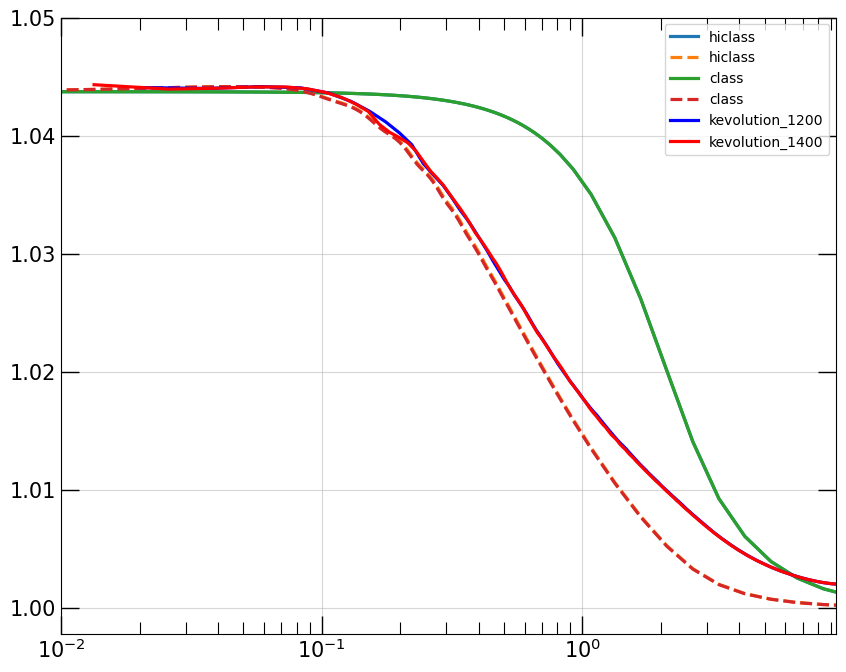

In [349]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8), sharex=True)
plt.subplots_adjust(hspace=0.012, wspace=0.23)

axs.plot(kk,mu_lin_hi,linewidth=2.3, linestyle="-", label = 'hiclass')
axs.plot(kk,mu_nl_hi,linewidth=2.3, linestyle="--", label = 'hiclass')
axs.plot(kk,mu_lin_class[0],linewidth=2.3, linestyle="-", label = 'class')
axs.plot(kk,mu_nl_class[0],linewidth=2.3, linestyle="--", label = 'class')
axs.plot(k_400,mu_smooth[0],linewidth=2.3, linestyle="-",c = "blue", label = 'kevolution_1200')
#axs.plot(k_1,mu_1280[0],linewidth=2.3, linestyle="--",c = "black", label = 'kevolution_3840')
#axs.plot(k_600,mu_smooth_600[0],linewidth=2.3, linestyle="-",c = "orange", label = 'kevolution_1800')
axs.plot(k_470,mu_smooth_470[0],linewidth=2.3, linestyle="-",c = "red", label = 'kevolution_1400')

axs.tick_params("both", length=13, width=1, which="major")
axs.tick_params("both", length=8.5, width=0.8, which="minor")
axs.tick_params(direction="in", which="major", labelsize=15)
axs.tick_params(direction="in", which="minor")
axs.yaxis.set_ticks_position("both")
axs.xaxis.set_ticks_position("both")
axs.set_xscale("log")
#axs.set_yscale("log")
axs.set_ylim([None,1.05])
axs.set_xlim([1.e-2,9.42])
axs.grid(alpha = 0.5)
axs.legend()

In [193]:
rho_m

1.584547399766202e-08

In [192]:
rho_m_kev(0)

1.5845174319820027e-08